In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, LSTM, Reshape, Dropout, LeakyReLU, Conv1D, Lambda
from keras.callbacks import EarlyStopping
from keras.models import load_model
from keras.initializers import Zeros
import pickle
import itertools
import random

data0 = pd.read_csv('data/data_0.csv')
data1 = pd.read_csv('data/data_1.csv')
data2 = pd.read_csv('data/data_2.csv')

VARIABLES_TO_FORECAST = [
    "non_shiftable_load",
    "dhw_demand",
    "cooling_demand",
    "solar_generation",
    "carbon_intensity",   
]

LOOKBACK = 48
OUT_STEPS = 48 # the number of hours we want to predict
model_name = 'NN'

USE_VAE = False
USE_PCA = False

TRESHOLD_BEST_FEATURES = {f: 0.2 for f in VARIABLES_TO_FORECAST}
TRESHOLD_BEST_FEATURES['cooling_demand'] = 0.15

# src_data = pd.concat([data0.iloc[:577], data1.iloc[:577], data2.iloc[:577]], ignore_index=True)
src_data = data0
columns_to_keep = {}

In [53]:
import tensorflow as tf
import tensorflow.keras as keras

from tensorflow.keras import backend as K
from tensorflow.keras.layers import Dense, Input, Lambda
from tensorflow.keras.models import Model
import pandas as pd

from tqdm.keras import TqdmCallback

tf.keras.utils.set_random_seed(42)

VARIABLES_TO_FORECAST = [
    "non_shiftable_load",
    "dhw_demand",
    "cooling_demand",
    "solar_generation",
    "carbon_intensity",   
]

def sampling(args):
    import keras.backend as K

    z_mean, z_log_sigma, latent_dim = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0., stddev=1.)
    return z_mean + K.exp(z_log_sigma) * epsilon

class VAE2():
    def __init__(self, encoder_path=None, base_dir='my_models/models', act='swish', init='glorot_uniform'):
        self.act = act
        self.init = init
        self.encoder = encoder_path
        self.base_dir = base_dir

    def build_autoencoder(self, dims, act=None, init=None):
        """
        Fully connected auto-encoder model, symmetric.
        Arguments:
            dims: list of number of units in each layer of encoder. dims[0] is input dim, dims[-1] is units in hidden layer.
                The decoder is symmetric with encoder. So number of layers of the auto-encoder is 2*len(dims)-1
            act: activation, not applied to Input, Hidden and Output layers
        return:
            (ae_model, encoder_model), Model of autoencoder and model of encoder
        """
        if act is None:
            act = self.act

        if init is None:
            init = self.init

        n_stacks = len(dims) - 1
        # input
        inputs = Input(shape=(dims[0],), name='input')
        x = inputs
        # internal layers in encoder
        for i in range(n_stacks-1):
            x = Dense(dims[i + 1], activation=act, kernel_initializer=init, name='encoder_%d' % i)(x)

        # hidden layer
        #encoded = Dense(dims[-1], kernel_initializer=init, name='encoder_%d' % (n_stacks - 1))(x)  # hidden layer, features are extracted from here
        #--- Custom Latent Space Layer
        z_mean = Dense(units=dims[-1], name='Z-Mean')(x) # Mean component
        z_log_sigma = Dense(units=dims[-1], name='Z-Log-Sigma')(x) # Standard deviation component
        z = Lambda(sampling, name='Z-Sampling-Layer')([z_mean, z_log_sigma, dims[-1]]) # Z sampling layer

        latent_inputs = Input(shape=(dims[-1],), name='Input-Z-Sampling')
        x = latent_inputs
        # internal layers in decoder
        for i in range(n_stacks-1, 0, -1):
            x = Dense(dims[i], activation=act, kernel_initializer=init, name='decoder_%d' % i)(x)

        #--- Output Layer Decoder
        outputs = Dense(dims[0], activation='linear', name='output')(x)

        # Instantiate a VAE model
        encoder = Model(inputs, [z_mean, z_log_sigma, z], name='Encoder-Model')
        decoder = Model(latent_inputs, outputs, name='Decoder-Model')

        # Define outputs from a VAE model by specifying how the encoder-decoder models are linked
        output_vae = decoder(encoder(inputs)[2]) # note, outputs available from encoder model are z_mean, z_log_sigma and z. We take z by specifying [2]

        vae = Model(inputs=inputs, outputs=output_vae, name='VAE')

        # Reconstruction loss compares inputs and outputs and tries to minimise the difference
        r_loss = dims[0] * keras.losses.mse(inputs, output_vae)  # use MSE

        # KL divergence loss compares the encoded latent distribution Z with standard Normal distribution and penalizes if it's too different
        kl_loss =  -0.5 * K.sum(1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma), axis = 1)

        # The VAE loss is a combination of reconstruction loss and KL loss
        vae_loss = K.mean(r_loss + kl_loss)

        # Add loss to the model and compile it
        vae.add_loss(vae_loss)
        vae.compile(optimizer='adam')

        return vae, encoder
    
    def apply(self, df, to_forecast, out_steps, latent_dim=5, train_again=False):
        columns_to_keep = [f"{to_forecast}_future{i}" for i in range(1, out_steps+1)] + ['hour', 'day_type']
        
        df_keep = df[columns_to_keep]
        df_reduce = df.drop(columns_to_keep, axis=1)

        if self.encoder is None or train_again:
            print('-> Training encoder...')
            xs = df_reduce
            dims = [xs.shape[-1], 64, 32, latent_dim]
            autoencoder, encoder = self.build_autoencoder(dims)
            autoencoder.fit(xs, xs, batch_size=64, epochs=2000, verbose=0, callbacks=[TqdmCallback(verbose=0),
                    EarlyStopping(monitor='loss', patience=10, verbose=0)])
            encoder.save(f'{self.base_dir}/encoder_{to_forecast}.keras')
        else:
            print('-> Loading encoder from: {}'.format(self.encoder))
            encoder = tf.keras.models.load_model(self.encoder, safe_mode=False)
            xs = df_reduce

        reduced_df = pd.DataFrame(encoder.predict(xs)[-1], columns=['Z{}'.format(i) for i in range(latent_dim)])
        return pd.concat([df_keep, reduced_df], axis=1)

In [54]:
def plot_history(history, to_forecast):
    plt.figure(figsize=(7, 5))
    plt.plot(history.history['loss'], label='train')
    if 'val_loss' in history.history:
        plt.plot(history.history['val_loss'], label='test')
    plt.legend()
    plt.show()
    # plt.savefig(f'images/loss_curves/{model_name}_{to_forecast}.png')

<Axes: xlabel='non_shiftable_load', ylabel='Density'>

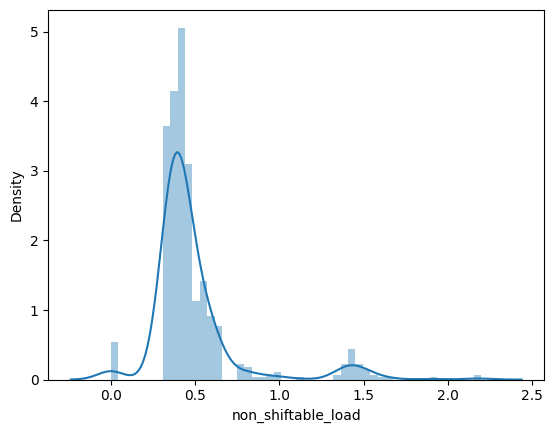

In [55]:
data = data0[:577+OUT_STEPS].copy()

data[data['non_shiftable_load'] > 2.3] = 0

import warnings
warnings.filterwarnings("ignore")
sns.distplot(data['non_shiftable_load'])

In [56]:
to_forecast = 'non_shiftable_load'

# create lag features with pd.shift
columns = data.columns

for i in range(1, LOOKBACK):
    for f in columns:
        data[f"{f}_lag{i}"] = data[f].shift(i).values

# create yhat for the next 48 hours
for i in range(1, OUT_STEPS+1):
    data[f"{to_forecast}_future{i}"] = data[to_forecast].shift(-i).values

# drop rows with NaN values
data.dropna(inplace=True)

data.index = pd.RangeIndex(len(data.index))

scaler = StandardScaler()
data = pd.DataFrame(scaler.fit_transform(data), columns=data.columns)

data.shape

(530, 1440)

In [57]:
vae = VAE2(base_dir='models')

data2 = vae.apply(data, to_forecast, latent_dim=5, train_again=True, out_steps=OUT_STEPS)

data2.shape

-> Training encoder...


 10%|▉         | 196/2000 [00:10<01:40, 17.87epoch/s, loss=554]  


17/17 [==============================] - 0s 2ms/step


(530, 55)

In [58]:
data2

,non_shiftable_load_future1,non_shiftable_load_future2,non_shiftable_load_future3,non_shiftable_load_future4,non_shiftable_load_future5,non_shiftable_load_future6,non_shiftable_load_future7,non_shiftable_load_future8,non_shiftable_load_future9,non_shiftable_load_future10,...,non_shiftable_load_future46,non_shiftable_load_future47,non_shiftable_load_future48,hour,day_type,Z0,Z1,Z2,Z3,Z4
0,-0.475166,-0.480385,-0.484999,-0.544028,-0.495157,-0.494822,-0.380691,-0.476779,3.294548,-0.314503,...,0.196377,-0.238205,-0.469016,1.649751,0.935719,-0.150839,-2.122375,-4.618124,-0.830273,-1.674170
1,-0.480408,-0.485021,-0.544052,-0.495055,-0.494551,-0.377267,-0.476607,3.294455,-0.314502,-0.163802,...,-0.239505,-0.469540,-0.475620,-1.552042,1.408034,-0.117214,-2.178875,-5.388154,-3.904094,-0.695035
2,-0.485044,-0.544074,-0.495078,-0.494450,-0.377007,-0.474056,3.294437,-0.314157,-0.163819,-0.157221,...,-0.470880,-0.476145,-0.480823,-1.412834,1.408034,1.722675,-0.918537,-3.812455,-3.296549,1.497960
3,-0.544098,-0.495101,-0.494473,-0.376910,-0.473787,3.331293,-0.313993,-0.163492,-0.157239,-0.139896,...,-0.477486,-0.481349,-0.485424,-1.273625,1.408034,2.433964,-1.219580,-2.908278,-1.875085,2.021083
4,-0.495124,-0.494495,-0.376933,-0.473686,3.331192,-0.309962,-0.163336,-0.156913,-0.139917,-0.138987,...,-0.482690,-0.485951,-0.490226,-1.134417,1.408034,2.547546,-2.078597,-2.480368,-1.778698,1.806493
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
525,0.203530,-0.018149,-0.401133,-0.465736,-0.480440,-0.485347,-0.492592,-0.497960,-0.504373,-0.381221,...,0.210976,0.104452,0.141778,1.232126,1.408034,2.296130,-1.073127,-3.379865,3.092393,-5.603632
526,-0.018168,-0.401154,-0.465759,-0.480339,-0.485077,-0.490186,-0.497787,-0.504005,-0.381211,3.120626,...,0.103211,0.141352,-0.122092,1.371334,1.408034,1.020998,-2.106244,-3.368706,5.273856,-4.288023
527,-0.401177,-0.465781,-0.480363,-0.484975,-0.489915,-0.495428,-0.503831,-0.380858,3.120202,-0.302797,...,0.140117,-0.122560,-0.237718,1.510542,1.408034,-2.868354,-2.650558,-5.021622,2.303093,-2.549266
528,-0.465804,-0.480385,-0.484999,-0.489813,-0.495157,-0.501527,-0.380691,3.120130,-0.302797,-0.314503,...,-0.123840,-0.238205,-0.469016,1.649751,1.408034,-2.844730,-2.523361,-5.644298,-1.124325,-1.824317


Epoch 1/200
12/12 [==============================] - 1s 14ms/step - loss: 1.2228 - mae: 0.7003 - val_loss: 1.1109 - val_mae: 0.6337
Epoch 2/200
12/12 [==============================] - 0s 5ms/step - loss: 1.1003 - mae: 0.6341 - val_loss: 1.0685 - val_mae: 0.6118
Epoch 3/200
12/12 [==============================] - 0s 4ms/step - loss: 1.0543 - mae: 0.6051 - val_loss: 1.0494 - val_mae: 0.6033
Epoch 4/200
12/12 [==============================] - 0s 5ms/step - loss: 1.0242 - mae: 0.5889 - val_loss: 1.0393 - val_mae: 0.5988
Epoch 5/200
12/12 [==============================] - 0s 4ms/step - loss: 1.0137 - mae: 0.5803 - val_loss: 1.0331 - val_mae: 0.5961
Epoch 6/200
12/12 [==============================] - 0s 4ms/step - loss: 1.0020 - mae: 0.5761 - val_loss: 1.0290 - val_mae: 0.5947
Epoch 7/200
12/12 [==============================] - 0s 4ms/step - loss: 0.9939 - mae: 0.5704 - val_loss: 1.0260 - val_mae: 0.5934
Epoch 8/200
12/12 [==============================] - 0s 4ms/step - loss: 0.9938 - 

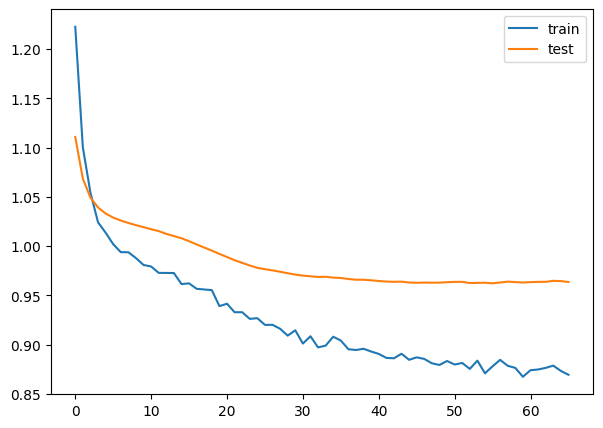

In [59]:
X = data2.drop([f"{to_forecast}_future{i}" for i in range(1, OUT_STEPS+1)], axis=1)
Y = data2[[f"{to_forecast}_future{i}" for i in range(1, OUT_STEPS+1)]]

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, shuffle=False, random_state=42)

# # dense model
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.35),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(OUT_STEPS, activation='linear')
])

callbacks = [EarlyStopping(monitor='val_loss', min_delta = 0.00001, patience=10, mode='auto', restore_best_weights=True)]

model.compile(loss='mse', optimizer='adam', metrics=['mae'])
history = model.fit(X_train, Y_train, epochs=200, verbose=1, validation_data=(X_test, Y_test), callbacks=callbacks)
model.save(f'models/{model_name}_{to_forecast}.keras')

plot_history(history, to_forecast)

# model = load_model(f'my_models/models/{model_name}_{to_forecast}.keras')

In [60]:
mse = model.evaluate(X_test, Y_test, verbose=0)[0]
print(f'{to_forecast} MSE: {mse}')

non_shiftable_load MSE: 0.9622436165809631


In [61]:
def plot_residuals_distribution(y_true, y_pred, to_forecast):
    errors = y_pred - y_true
    errors_plot = errors[[f"{to_forecast}_future1", f"{to_forecast}_future10", f"{to_forecast}_future20", f"{to_forecast}_future30", f"{to_forecast}_future40"]]
    errors_plot = np.abs(errors_plot)
    
    # rename columns for plotting
    errors_plot.columns = ["1h", "10h", "20h", "30h", "40h"]

    sns.violinplot(errors_plot)#, hue="alive")
    plt.show()
    return errors

5/5 [==============================] - 0s 2ms/step


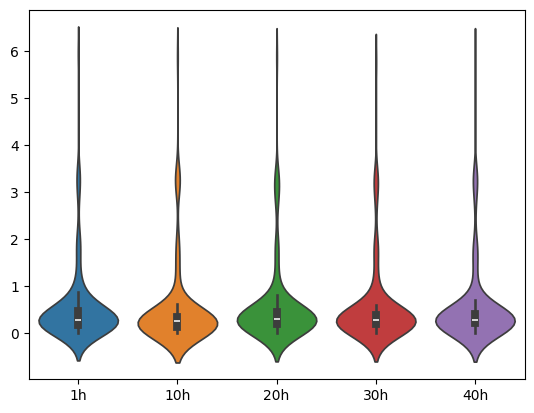

<Figure size 1200x600 with 0 Axes>

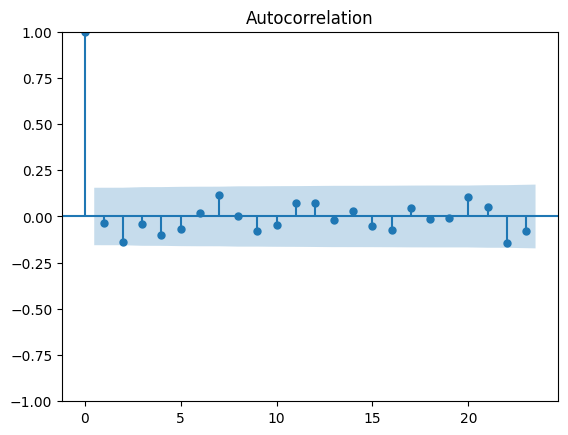

In [62]:
# plot residuals
Y_pred = model.predict(X_test)

# errors = plot_residuals(Y_test, Y_pred, to_forecast)
errors = plot_residuals_distribution(Y_test, Y_pred, to_forecast)

# residuals autocorrelation
from statsmodels.graphics.tsaplots import plot_acf
plt.figure(figsize=(12, 6))
plot_acf(errors[f"{to_forecast}_future{OUT_STEPS//2}"])
plt.show()